# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

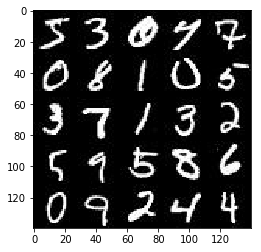

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')
pyplot.savefig('./mnist.png')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

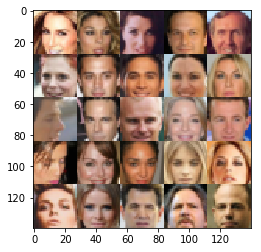

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

pyplot.savefig('./face.png')

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/ducvu/anaconda2/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3  --> 16,16,64
        conv1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        # Leaky ReLU
        conv1 = tf.maximum(alpha * conv1, conv1) 
 
        # Second layer is 8x8x128
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides = 2, padding = 'same')
        # add batch normalization to the layer conv2
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        # Leaky ReLU
        conv2 = tf.maximum(alpha * conv2, conv2) 
        
 
        # Third layer is 4x4x256
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides = 2, padding = 'same')
        # add batch normalization to the layer conv3
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        # Leaky ReLU
        conv3 = tf.maximum(alpha * conv3, conv3) 
        
        # Flatten it
        flat = tf.reshape(conv3, shape=[-1, 4 * 4 * 256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
              
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.


![DCGAN Generator](dcgan-modified.png)

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer, 7x7x512
        conv1 = tf.layers.dense(z, 7*7*512, activation=None)
        #reshape the layer x1 to start the convolutional stack
        conv1 = tf.reshape(conv1, shape=[-1, 7, 7, 512])
        # add batch normalization to the layer conv1
        conv1 = tf.layers.batch_normalization(conv1, training = is_train)
        # Leaky ReLU
        conv1 = tf.maximum(alpha * conv1, conv1)

    
        # second transposed 2D convolution layer, 7x7x256
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides = 1, padding = 'same')
        # add batch normalization to the layer conv2
        conv2 = tf.layers.batch_normalization(conv2, training = is_train)
        # Leaky ReLU
        conv2 = tf.maximum(alpha * conv2, conv2)

        
        # third transposed 2D convolution layer, 14x14x128
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides = 2, padding = 'same')
        # add batch normalization to the layer x3
        conv3 = tf.layers.batch_normalization(conv3, training = is_train)
        # Leaky ReLU
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides = 2, padding = 'same')
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)

    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):

    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Real input images with rank 4 of n_images, image_width, image_height, and image_channels
    n_samples, image_width, image_height, image_channels = data_shape
    out_channel_dim = image_channels 
    
    #Network Inputs
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    #Model Loss    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    #Optimizers    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)  
    
    
    losses = []
    steps = 0
    print_every=10
    show_every=100
    n_images = 25
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                #rescale to pass to D
                batch_images = batch_images*2.0
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)

                       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7841... Generator Loss: 0.3974
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 0.7938
Epoch 1/2... Discriminator Loss: 2.2377... Generator Loss: 0.1965
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 1.8940... Generator Loss: 0.2597
Epoch 1/2... Discriminator Loss: 1.8752... Generator Loss: 0.3156
Epoch 1/2... Discriminator Loss: 1.5551... Generator Loss: 0.3899
Epoch 1/2... Discriminator Loss: 0.7779... Generator Loss: 1.0231
Epoch 1/2... Discriminator Loss: 0.7190... Generator Loss: 1.1686
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.7812


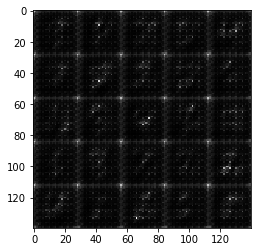

Epoch 1/2... Discriminator Loss: 1.6036... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 1.6239... Generator Loss: 1.0255
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 1.6121... Generator Loss: 1.0427
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 0.8274
Epoch 1/2... Discriminator Loss: 1.6136... Generator Loss: 0.3232
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 0.5958


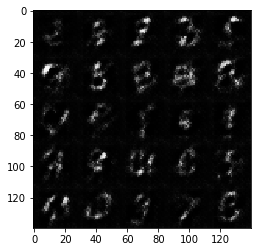

Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 1.2073
Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 1.0794
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 0.3506
Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 0.9909
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.3919
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.6128


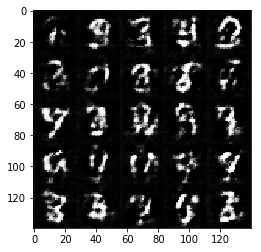

Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.1734
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 0.6726
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.5014
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 0.8749... Generator Loss: 0.8100
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 1.1009
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 1.1838
Epoch 1/2... Discriminator Loss: 0.8703... Generator Loss: 1.0618


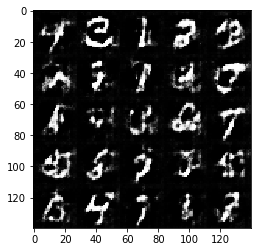

Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 1.4072
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 1.1235
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 0.9295... Generator Loss: 0.8677
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.5172
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 0.7663


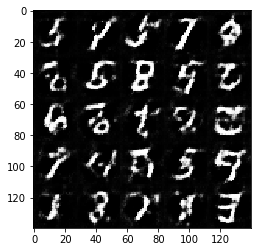

Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 0.8593
Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 1.0899
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 0.9128
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 1.7013
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 1.2338
Epoch 1/2... Discriminator Loss: 0.7300... Generator Loss: 1.4302
Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 0.9702


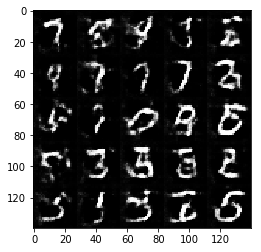

Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 1.2119
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 1.3163
Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.3468
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 1.5420
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.8825
Epoch 1/2... Discriminator Loss: 0.8462... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 1.9713
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.5446
Epoch 1/2... Discriminator Loss: 1.8332... Generator Loss: 0.2197
Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 1.2609


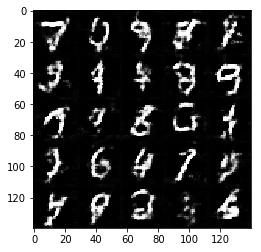

Epoch 1/2... Discriminator Loss: 1.5167... Generator Loss: 0.3621
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 1.0770
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.6108
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 0.9763
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.1546
Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 0.8960
Epoch 1/2... Discriminator Loss: 1.1081... Generator Loss: 0.6470
Epoch 1/2... Discriminator Loss: 2.0288... Generator Loss: 0.2021


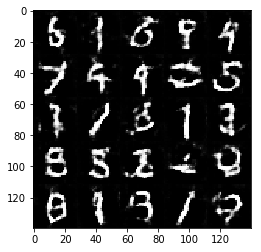

Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9003
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 0.8845
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.4485
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 1.1505
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.0674
Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 0.2537
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 0.9132... Generator Loss: 1.0683


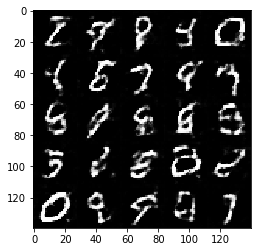

Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.0384
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 2.0889... Generator Loss: 0.1909
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 0.5493
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.1156
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.4283
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.5835


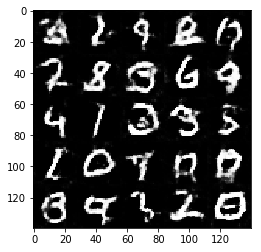

Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.4556
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.3718


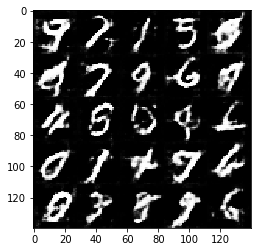

Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 1.5438
Epoch 1/2... Discriminator Loss: 0.8620... Generator Loss: 1.5341
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.5582
Epoch 1/2... Discriminator Loss: 1.1222... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.2646
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.3234
Epoch 1/2... Discriminator Loss: 1.1182... Generator Loss: 1.1209
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 0.9104
Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 0.6620


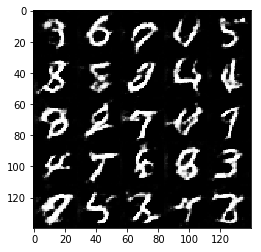

Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 1.7059
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.4248
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.3582
Epoch 1/2... Discriminator Loss: 0.8924... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 0.7155... Generator Loss: 1.6967
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 0.8020... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 2.1592... Generator Loss: 0.2198
Epoch 1/2... Discriminator Loss: 0.7794... Generator Loss: 0.8968


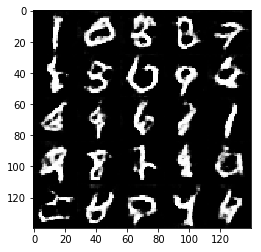

Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.4075
Epoch 1/2... Discriminator Loss: 0.7089... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.3625
Epoch 1/2... Discriminator Loss: 1.8386... Generator Loss: 0.2573
Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 0.9247... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.1744
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.5827


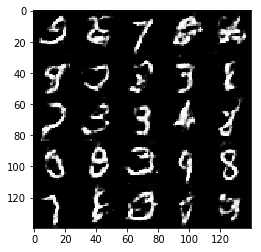

Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 0.9387
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 2.0566
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 1.4742
Epoch 1/2... Discriminator Loss: 0.7049... Generator Loss: 1.1302
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 0.7049... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 0.7356


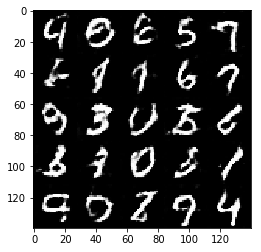

Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 0.6711
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 0.6838... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 0.9447
Epoch 1/2... Discriminator Loss: 0.5745... Generator Loss: 1.4879
Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 1.2986
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.1114
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.5221


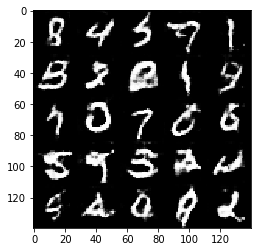

Epoch 1/2... Discriminator Loss: 0.9440... Generator Loss: 1.1515
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 0.6512... Generator Loss: 1.1351
Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 0.7075... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.3221
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.4253
Epoch 1/2... Discriminator Loss: 0.6147... Generator Loss: 1.8352


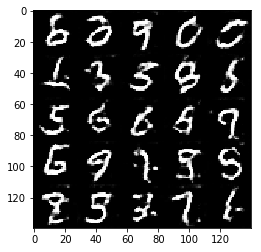

Epoch 1/2... Discriminator Loss: 0.7374... Generator Loss: 1.5181
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 2.3242
Epoch 1/2... Discriminator Loss: 1.6081... Generator Loss: 0.3833
Epoch 1/2... Discriminator Loss: 0.9008... Generator Loss: 1.4712
Epoch 1/2... Discriminator Loss: 0.6778... Generator Loss: 1.4659
Epoch 1/2... Discriminator Loss: 0.9031... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 2.2571
Epoch 1/2... Discriminator Loss: 0.7600... Generator Loss: 1.3385
Epoch 1/2... Discriminator Loss: 0.6274... Generator Loss: 1.7054
Epoch 1/2... Discriminator Loss: 0.6133... Generator Loss: 1.0823


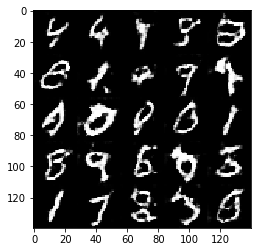

Epoch 1/2... Discriminator Loss: 0.9095... Generator Loss: 0.6703
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.0413
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 0.6345... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 1.5711... Generator Loss: 0.3116
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 0.5160
Epoch 1/2... Discriminator Loss: 0.5312... Generator Loss: 1.3694
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.3486
Epoch 2/2... Discriminator Loss: 1.0106... Generator Loss: 0.7768


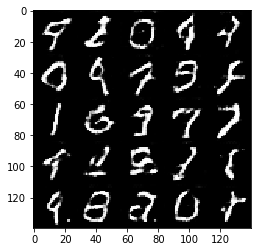

Epoch 2/2... Discriminator Loss: 0.6632... Generator Loss: 1.9265
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.4781
Epoch 2/2... Discriminator Loss: 0.8397... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 0.7458... Generator Loss: 1.1079
Epoch 2/2... Discriminator Loss: 0.6349... Generator Loss: 1.0202
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 0.8740
Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 2.4029... Generator Loss: 4.4222
Epoch 2/2... Discriminator Loss: 0.6993... Generator Loss: 1.1704
Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 1.1856


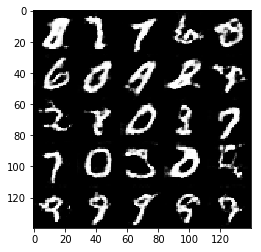

Epoch 2/2... Discriminator Loss: 0.6349... Generator Loss: 1.2842
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 0.5686
Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.5016
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.5913
Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 0.5059
Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 0.8555


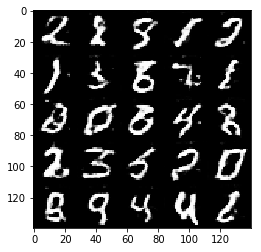

Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 0.5950
Epoch 2/2... Discriminator Loss: 0.5647... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 1.1630
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 0.6450
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 1.8215... Generator Loss: 0.2320
Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.2277
Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 1.4405
Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 1.6047


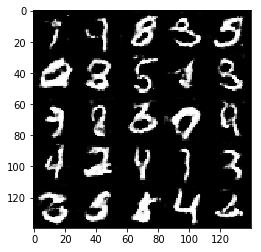

Epoch 2/2... Discriminator Loss: 0.4420... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 0.8947
Epoch 2/2... Discriminator Loss: 0.4750... Generator Loss: 1.4965
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 0.7781... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 1.1690
Epoch 2/2... Discriminator Loss: 0.6672... Generator Loss: 1.2949
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 1.4068
Epoch 2/2... Discriminator Loss: 1.0869... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 0.5194... Generator Loss: 1.6047


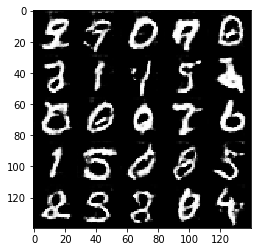

Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 2.3824
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 0.7560... Generator Loss: 1.2728
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 1.1626
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 0.6540... Generator Loss: 0.9998
Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 1.0767
Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.1970


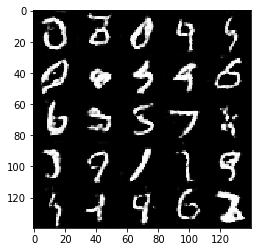

Epoch 2/2... Discriminator Loss: 1.5447... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.6814
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 1.8753
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.5722
Epoch 2/2... Discriminator Loss: 0.5681... Generator Loss: 1.3919
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.4498
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 0.8613


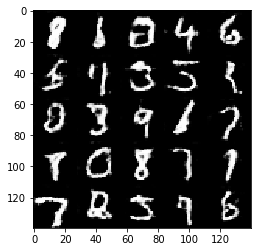

Epoch 2/2... Discriminator Loss: 0.7246... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 0.4191... Generator Loss: 1.5303
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 0.9297
Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 1.3262
Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 2.0060
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 0.4466... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 0.5769... Generator Loss: 1.2094
Epoch 2/2... Discriminator Loss: 0.6190... Generator Loss: 1.0304


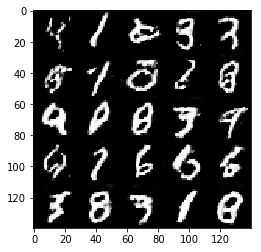

Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 0.4614... Generator Loss: 1.4555
Epoch 2/2... Discriminator Loss: 1.7542... Generator Loss: 0.3026
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 0.9660
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 0.9005
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.1381
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 0.3373... Generator Loss: 1.5312
Epoch 2/2... Discriminator Loss: 0.5351... Generator Loss: 1.3439


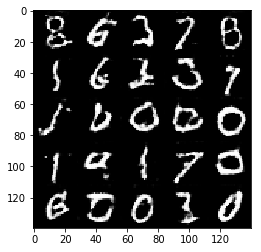

Epoch 2/2... Discriminator Loss: 0.2861... Generator Loss: 1.9040
Epoch 2/2... Discriminator Loss: 0.8198... Generator Loss: 1.3795
Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 0.4702
Epoch 2/2... Discriminator Loss: 0.4661... Generator Loss: 2.0705
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 0.8636
Epoch 2/2... Discriminator Loss: 0.4918... Generator Loss: 1.3515
Epoch 2/2... Discriminator Loss: 0.6433... Generator Loss: 1.2249
Epoch 2/2... Discriminator Loss: 0.4637... Generator Loss: 1.3668
Epoch 2/2... Discriminator Loss: 0.7440... Generator Loss: 1.3828
Epoch 2/2... Discriminator Loss: 1.6892... Generator Loss: 0.3330


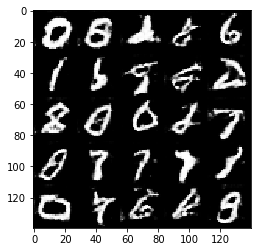

Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 1.9947
Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 1.3141
Epoch 2/2... Discriminator Loss: 0.3851... Generator Loss: 1.6881
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.1699
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 2.7120
Epoch 2/2... Discriminator Loss: 0.4928... Generator Loss: 1.2373
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 0.9807
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.7753


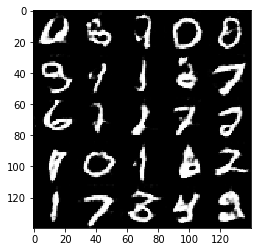

Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 1.2614
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 0.3432... Generator Loss: 1.7027
Epoch 2/2... Discriminator Loss: 1.3417... Generator Loss: 0.4206
Epoch 2/2... Discriminator Loss: 0.4490... Generator Loss: 1.8208
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 0.6575... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 0.6652... Generator Loss: 0.9458
Epoch 2/2... Discriminator Loss: 0.6841... Generator Loss: 1.2637
Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 1.7922


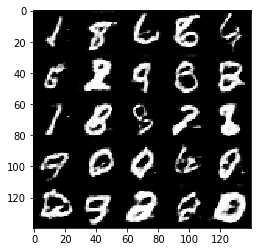

Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 1.1792
Epoch 2/2... Discriminator Loss: 0.4370... Generator Loss: 1.9305
Epoch 2/2... Discriminator Loss: 0.6576... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 0.8276
Epoch 2/2... Discriminator Loss: 0.4906... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 2.2883
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.0848
Epoch 2/2... Discriminator Loss: 0.2942... Generator Loss: 1.8758
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.3476


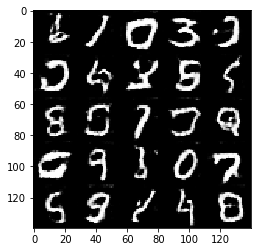

Epoch 2/2... Discriminator Loss: 0.3546... Generator Loss: 2.2208
Epoch 2/2... Discriminator Loss: 0.4562... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 0.7062... Generator Loss: 0.9114
Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 0.6304... Generator Loss: 1.0280
Epoch 2/2... Discriminator Loss: 0.4580... Generator Loss: 1.4442
Epoch 2/2... Discriminator Loss: 0.5804... Generator Loss: 1.6345
Epoch 2/2... Discriminator Loss: 0.6752... Generator Loss: 2.2791
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 2.0821
Epoch 2/2... Discriminator Loss: 0.5337... Generator Loss: 1.4044


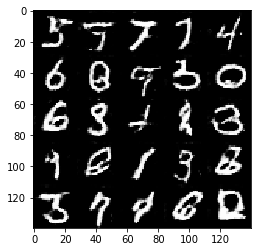

Epoch 2/2... Discriminator Loss: 0.3595... Generator Loss: 1.6036
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.5960
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 2.0061
Epoch 2/2... Discriminator Loss: 0.5746... Generator Loss: 1.2906
Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 2.5588
Epoch 2/2... Discriminator Loss: 0.3086... Generator Loss: 1.9450
Epoch 2/2... Discriminator Loss: 1.1945... Generator Loss: 0.4753
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 0.5287... Generator Loss: 1.2038


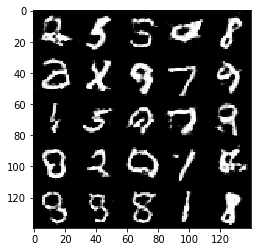

Epoch 2/2... Discriminator Loss: 0.4943... Generator Loss: 1.3030
Epoch 2/2... Discriminator Loss: 0.3227... Generator Loss: 2.0000
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 0.7378
Epoch 2/2... Discriminator Loss: 0.5694... Generator Loss: 1.2977
Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 0.4809... Generator Loss: 1.3712
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.7692
Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 0.9543
Epoch 2/2... Discriminator Loss: 0.3656... Generator Loss: 1.7464
Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 0.7317


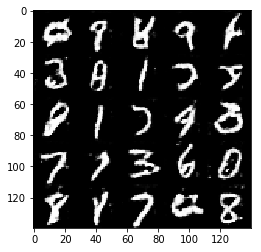

Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 1.9597
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 0.6513... Generator Loss: 1.0403
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 1.4875
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 0.4313... Generator Loss: 1.4099
Epoch 2/2... Discriminator Loss: 0.3965... Generator Loss: 1.4105
Epoch 2/2... Discriminator Loss: 0.3301... Generator Loss: 2.6324
Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 1.1669


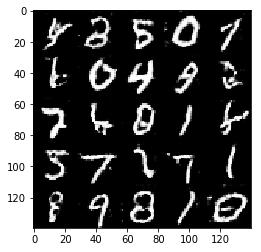

Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.0858
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 0.3633... Generator Loss: 1.5809
Epoch 2/2... Discriminator Loss: 0.6979... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.2207
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 0.4473... Generator Loss: 1.3891
Epoch 2/2... Discriminator Loss: 2.5599... Generator Loss: 0.2489
Epoch 2/2... Discriminator Loss: 0.3693... Generator Loss: 2.0864


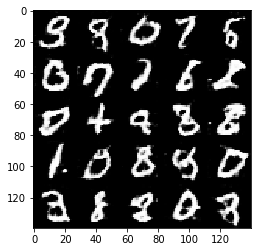

Epoch 2/2... Discriminator Loss: 0.2584... Generator Loss: 2.2755
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 2.3220
Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 0.6353
Epoch 2/2... Discriminator Loss: 0.3573... Generator Loss: 1.6433
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 0.6412... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 0.6058
Epoch 2/2... Discriminator Loss: 0.5411... Generator Loss: 1.6081


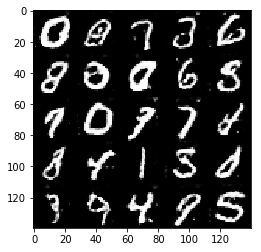

Epoch 2/2... Discriminator Loss: 0.5591... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 1.4152
Epoch 2/2... Discriminator Loss: 0.2898... Generator Loss: 1.9141


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9941... Generator Loss: 0.2849
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 3.4896
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 3.8470
Epoch 1/1... Discriminator Loss: 2.8808... Generator Loss: 0.1532
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 3.6661
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.8994
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 2.1027
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 2.4847


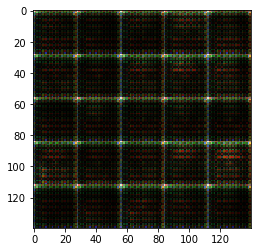

Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 2.6913
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.6354
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.7650


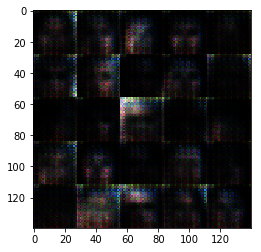

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8313


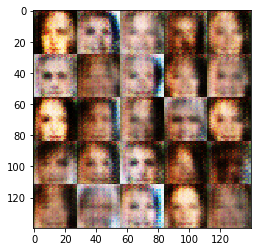

Epoch 1/1... Discriminator Loss: 1.9784... Generator Loss: 0.3519
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.7336... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 0.3391
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.8190... Generator Loss: 0.2726
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.0060


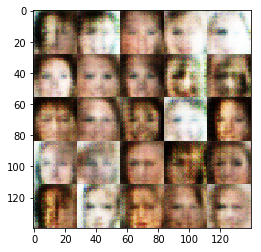

Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7947


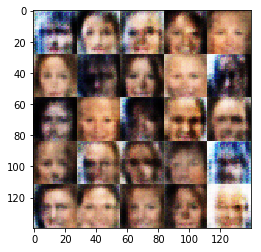

Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.5628


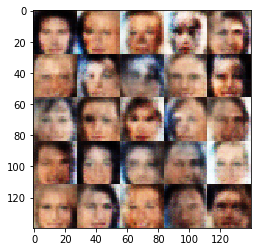

Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 0.4383


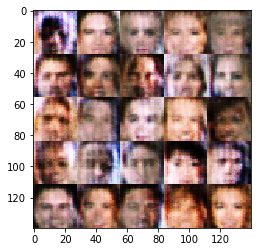

Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.9803


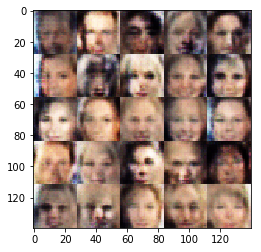

Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.6952


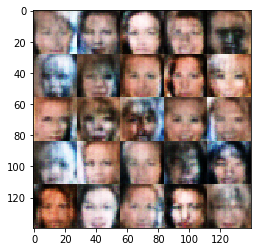

Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6809


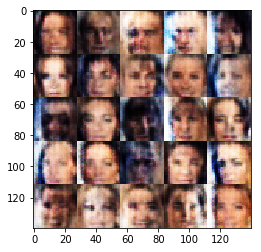

Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.8042


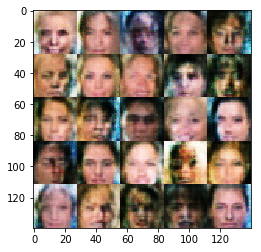

Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.6907


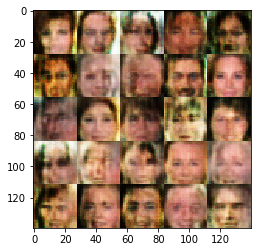

Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.8789


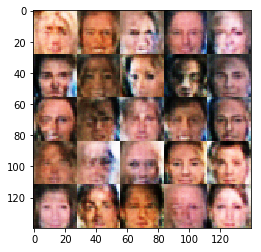

Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5610


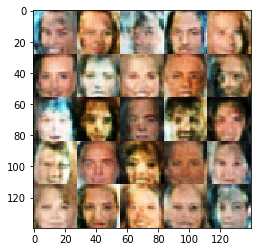

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9912


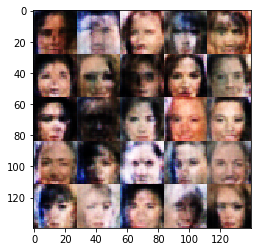

Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6143


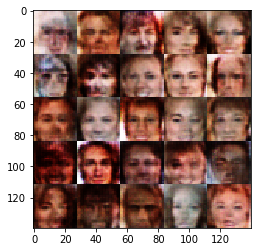

Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.7541


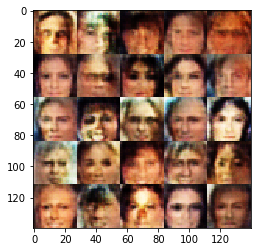

Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.7795


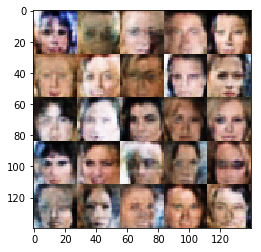

Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.9946


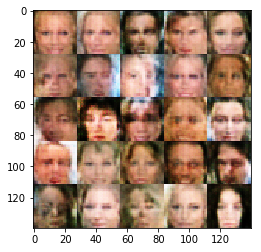

Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.9594


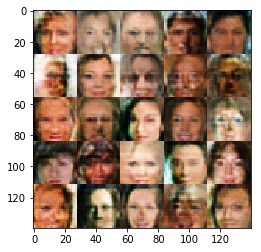

Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.4627


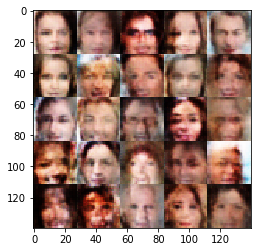

Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.6896


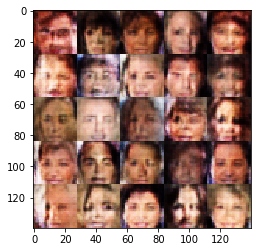

Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7043


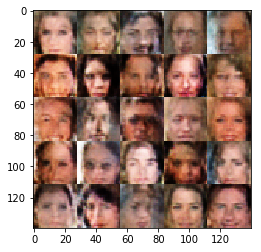

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.8061


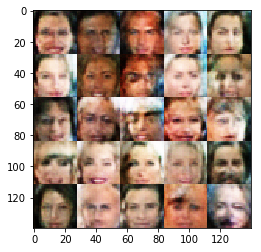

Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.5891


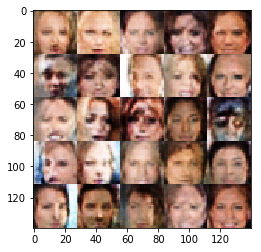

Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.5438


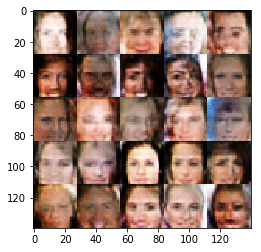

Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.4725


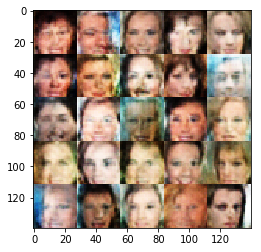

Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.7550


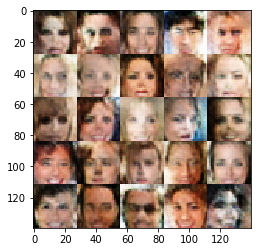

Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.3379
Epoch 1/1... Discriminator Loss: 1.6294... Generator Loss: 0.3420
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.5538


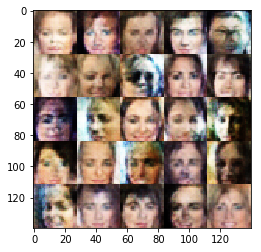

Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.7794


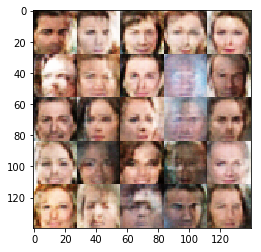

Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.6585


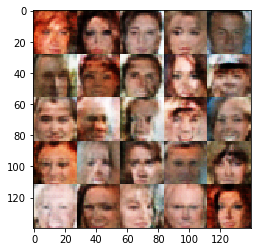

Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.4711


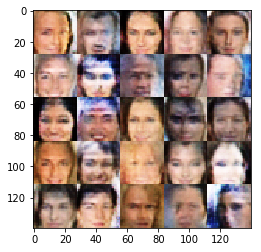

Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.0280


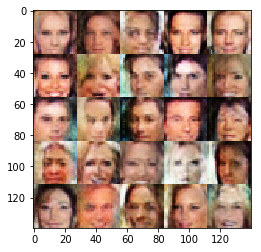

Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.9608... Generator Loss: 0.2693
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.6160


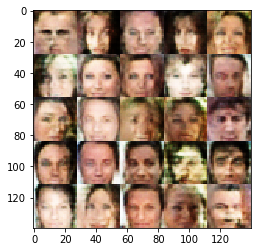

Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.3844
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.5076


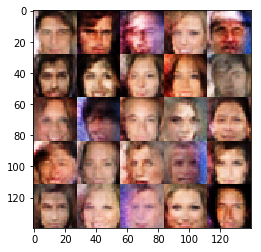

Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6548


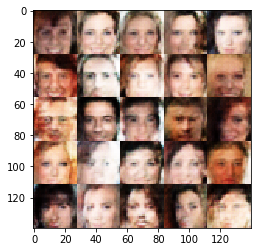

Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.3773
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6543


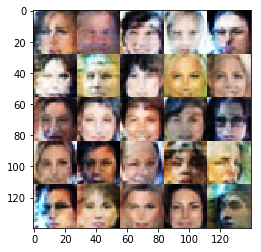

Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 0.8791


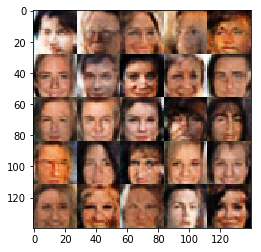

Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6350


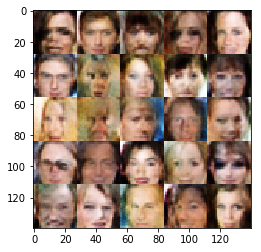

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.7074... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.7874


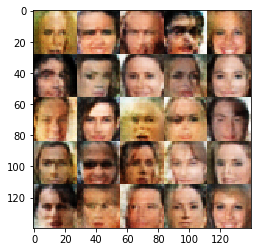

Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.8284


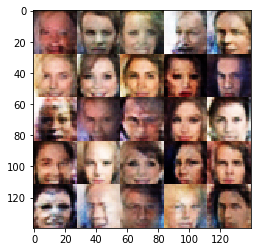

Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 0.7543


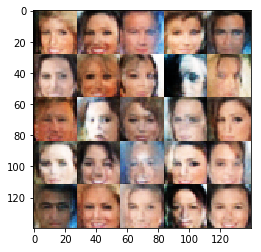

Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.6502


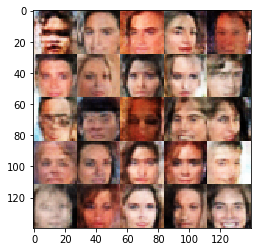

Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.7471


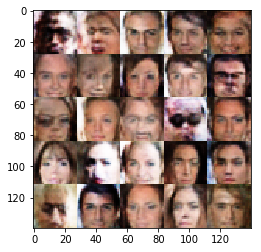

Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.8947... Generator Loss: 0.2668
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.9788


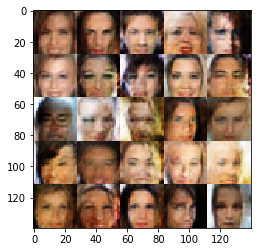

Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0399


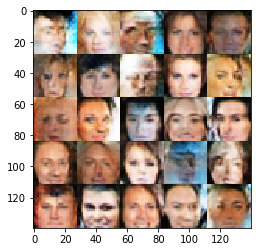

Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.6121


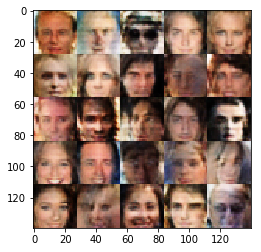

Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.3580


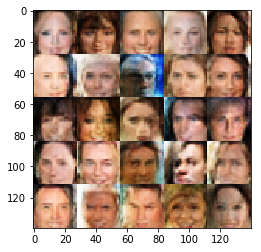

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.5656


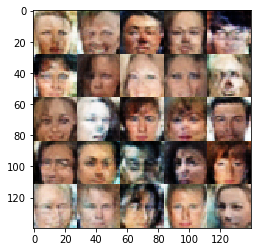

Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.6898


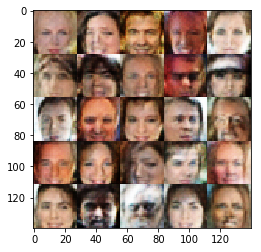

Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.7456


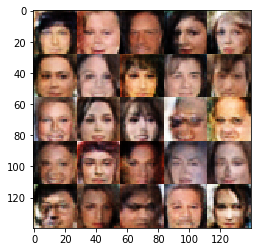

Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.8484


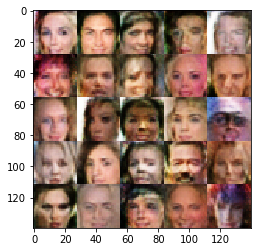

Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.6341... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.9059


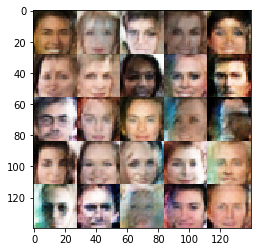

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.5835


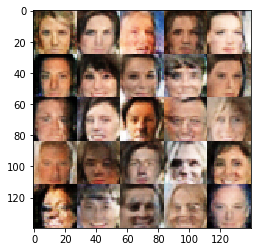

Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.4280
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.5897


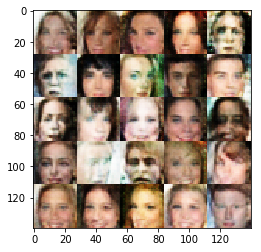

Epoch 1/1... Discriminator Loss: 1.7221... Generator Loss: 0.3311
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.7271


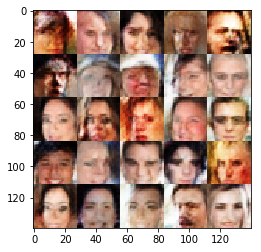

Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.4668
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.7222


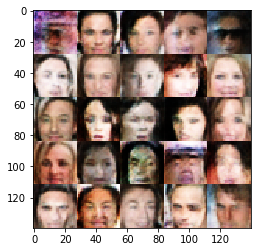

Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.7487... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.4273


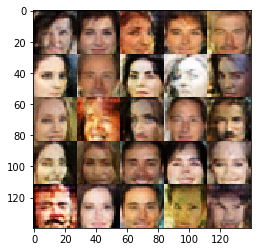

Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.6937


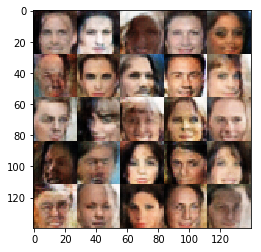

Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.4834


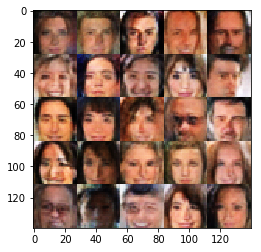

Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.7107


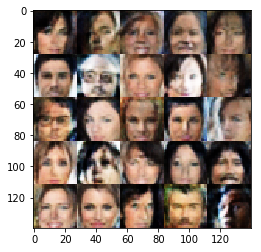

Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6090


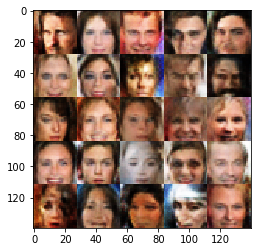

Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.3691
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.5717


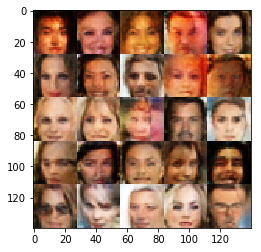

Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.5872


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.